In [1]:
import os
import sys
import importlib
os.chdir("../..")
directory_path = os.path.abspath(os.path.join("src"))
if directory_path not in sys.path:
    sys.path.append(directory_path)

import EyeTraumaAnalysis

In [2]:
print(directory_path)

C:\Users\ethan\PycharmProjects\EyeTraumaAnalysis\src


In [3]:
importlib.reload(EyeTraumaAnalysis);

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import cv2

In [5]:
images = ["11000.jpg", "11002.jpg", "11003.jpg", "11004.jpg", "11005.jpg", "11007.jpg", "11008.jpg", "11009.jpg",
          "11010.jpg", "11011.jpg", "12001.jpg", "10001.jpg", "10005.jpg", "10015.jpg", "10024.jpg", "00001_li.jpg", "00002_li.jpg", "00003_li.jpg", "00006_li.jpg", "00011_li.jpg", "00016_li.jpg", "00017_li.jpg", "00018_li.jpg"]

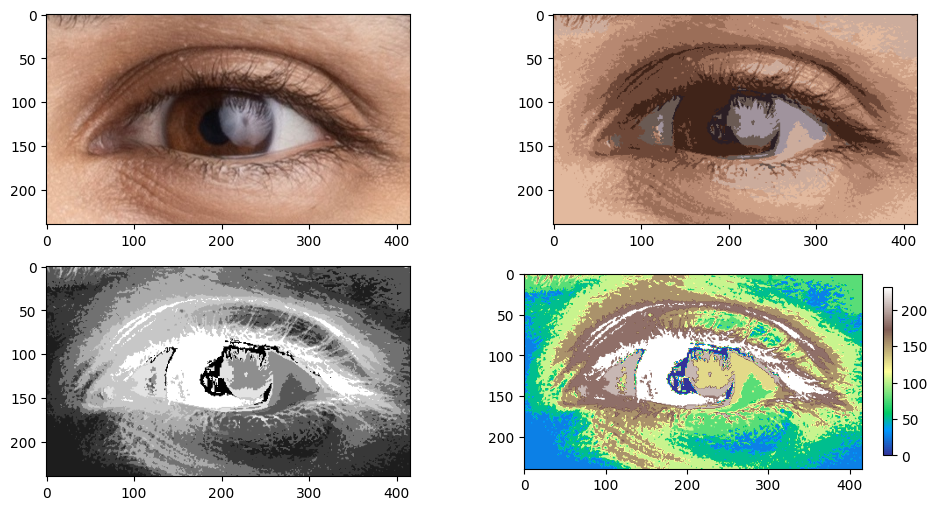

In [6]:
### Clustered View ### <-- for individual image use

image = EyeTraumaAnalysis.Image("data/01_raw/11000.jpg")
img_bgr = image.img
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
Z_hsv = img_hsv.reshape((-1,3))
# convert to np.float32
Z_hsv = np.float32(Z_hsv)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
ret,label,centers=cv2.kmeans(Z_hsv,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
centers = np.uint8(centers)
res_hsv = centers[label.flatten()]
res_hsv2 = res_hsv.reshape(img_hsv.shape)
res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
# res2 = cv2.cvtColor(res2, cv2.COLOR_RGB2GRAY)


# sort centers by HSV "value" - aka sort by grascale
centers_sorted = centers[centers[:, 2].argsort()]
kmeans_thresholds = []
for ind in range(K):
    kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
summed_image = np.zeros(kmeans_thresholds[0].shape)
for ind in range(K):
    summed_image += int(ind/K*255) * kmeans_thresholds[ind]

fig, axs = plt.subplots(2, 2, figsize=(12,6))
im0=axs.flat[0].imshow(img_bgr)
im1=axs.flat[1].imshow(res_bgr)
im2=axs.flat[2].imshow(summed_image, cmap="gray")
im3=axs.flat[3].imshow(summed_image, cmap="terrain")
plt.colorbar(im3,ax=axs.flat[3], shrink=0.8)

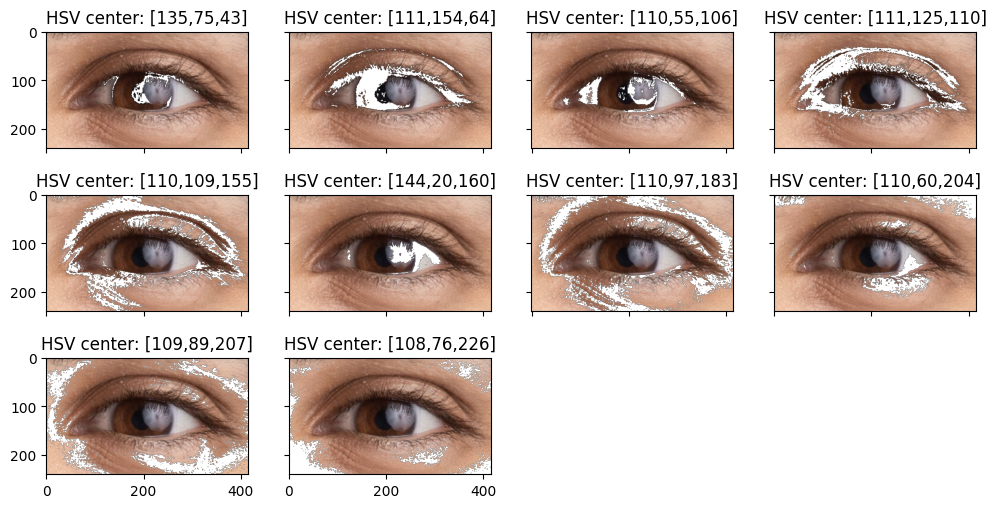

In [7]:
### Per Cluster Masking ### <-- for individual image use

row_ct = int(np.sqrt(K))
col_ct = int(np.ceil(K/row_ct))
fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
for ind in range(row_ct*col_ct):
    if ind < K:
        target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
        axs.flat[ind].imshow(target1)
        axs.flat[ind].set_title(
            f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
        #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
    else:
        # remove axes for empty cells
        axs.flat[ind].axis("off")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ethan\\PycharmProjects\\EyeTraumaAnalysis\\data\\kmeans_clustering_applied\\K-10\\clusted_view\\11000.png'

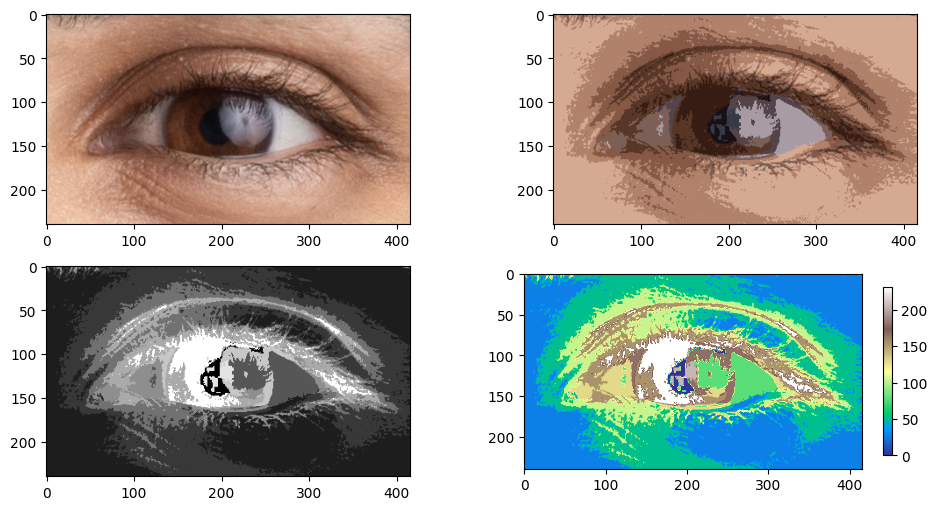

In [9]:
### Running Code on Several Images ###

K = 10
for image_sample in images:
    image = EyeTraumaAnalysis.Image(f"data/01_raw/{image_sample}")

    ## Clustered View
    img_bgr = image.img
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    Z_hsv = img_hsv.reshape((-1,3))
    Z_hsv = np.float32(Z_hsv)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,centers=cv2.kmeans(Z_hsv,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    res_hsv = centers[label.flatten()]
    res_hsv2 = res_hsv.reshape(img_hsv.shape)
    res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
    centers_sorted = centers[centers[:, 2].argsort()]
    kmeans_thresholds = []
    for ind in range(K):
        kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
    summed_image = np.zeros(kmeans_thresholds[0].shape)
    for ind in range(K):
        summed_image += int(ind/K*255) * kmeans_thresholds[ind]
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    im0=axs.flat[0].imshow(img_bgr)
    im1=axs.flat[1].imshow(res_bgr)
    im2=axs.flat[2].imshow(summed_image, cmap="gray")
    im3=axs.flat[3].imshow(summed_image, cmap="terrain")
    plt.colorbar(im3,ax=axs.flat[3], shrink=0.8)
    save_directory = f"{directory_path}".replace("src", "data")
    plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\K-{K}\\clusted_view\\{image_sample.split('.jpg')[0]}")

    ## Per Cluster Masking
    row_ct = int(np.sqrt(K))
    col_ct = int(np.ceil(K/row_ct))
    fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    for ind in range(row_ct*col_ct):
        if ind < K:
            target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
            axs.flat[ind].imshow(target1)
            axs.flat[ind].set_title(
                f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
            #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
        else:
            # remove axes for empty cells
            axs.flat[ind].axis("off")
    plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\K-{K}\\per_cluster_mask\\{image_sample.split('.jpg')[0]}")